# Practicle 9: Explainable AI with LIME

**Aim** Learn how to generate model explaininations using the *Local Interpretable Model-agnostic Explanations* (__[LIME](https://github.com/marcotcr/lime)__) toolbox. 

We be using the *Cleveland Heart Disease Data Set*, avialiable (__[here](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)__) through the University of California Irvine Machine Learning Repository. A CSV of the data has been posted in Keats. Please download it before the lab and place it in the same folder you are running this program from.

The dataset contains 14 clinical attributes from 303 indiviuduals. Each sample is a labelled with either presence (value 1) or absence (value 0)of heart disease. The features in the database are:
1. age: age in years 
2. sex: 1 = male; 0 = female
3. cp: chest pain type. 1= typical angina; 2 = atypical angina; 3 = non-anginal pain ; 4 = asymptomatic 
4. trestbps:resting blood pressure (in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl 
6. fbs:  fasting blood sugar > 120 mg/dl. 1 = true; 0 = false
7. restecg: resting electrocardiographic results. 0 = normal; 1: having ST-T wave abnormality; 2 = probable or definite left ventricular hypertrophy
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina. 1 = yes; 0 = no
10. oldpeak: ST segment depression induced by exercise relative to rest 
11. slope: the slope of the peak exercise ST segment. 1 = upsloping; 2 = flat; 3 = downsloping 
12. ca: number of major vessels (0-3) colored by flourosopy 
13. thal: Thalassemia. 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. target: Diagnosis of heart disease. Value 0 = < 50% diameter narrowing; Value 1 = 50% diameter narrowing 

## Step 1 Set-Up

Remember to install LIME *before* starting the tutorial: 

In [2]:
pip install seaborn

     |████████████████████████████████| 292 kB 18.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Import all toolboxes need to support the tutorial

In [5]:
# Import libraries necessary for this practical
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.layers import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import lime
from lime import lime_tabular

**Observing Model training** the following function will be used to obsevere the behaviour of the models after they have been trained. 
It plots the loss and accuracy of model after every training epoch

In [6]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

## Step 2 Load data and visualise key characteristics

Load the data using Pandas

In [7]:
data = pd.read_csv("heart.csv")
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

Plot the distubution of the target scores and gender in the dataset

<AxesSubplot:xlabel='sex', ylabel='count'>

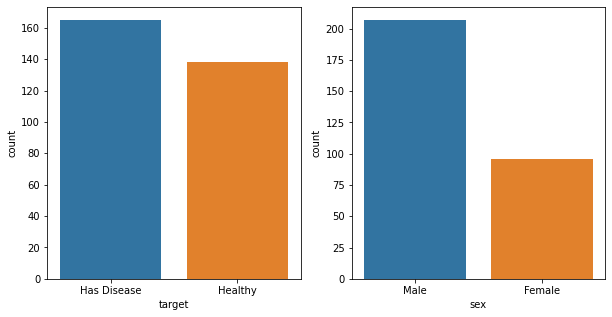

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=data, x=data.target.replace([1, 0], ['Has Disease', 'Healthy']), ax=ax1)
sns.countplot(data=data, x=data.sex.replace([0, 1], ['Female', 'Male']), ax=ax2)

Lets plot the distribution of disease by age

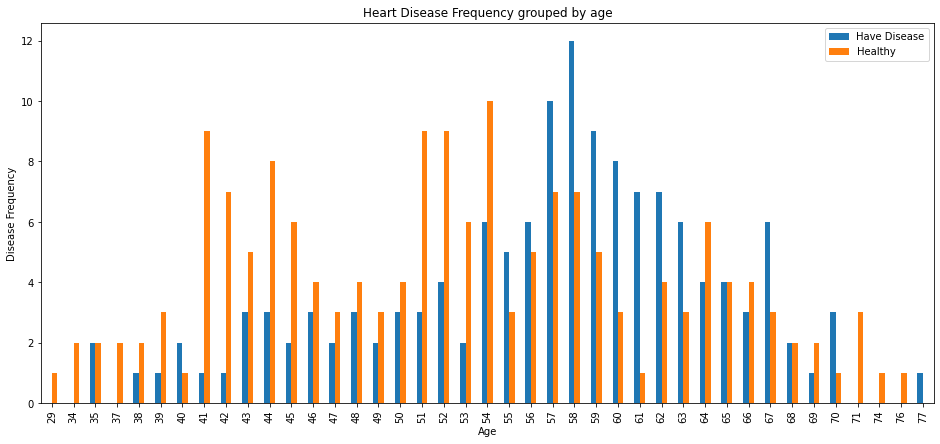

In [9]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(16, 7))
plt.title('Heart Disease Frequency grouped by age')
plt.xlabel('Age')
plt.ylabel('Disease Frequency')
plt.legend(["Have Disease", "Healthy"])

Then, let's plot the distribution of disease by gender

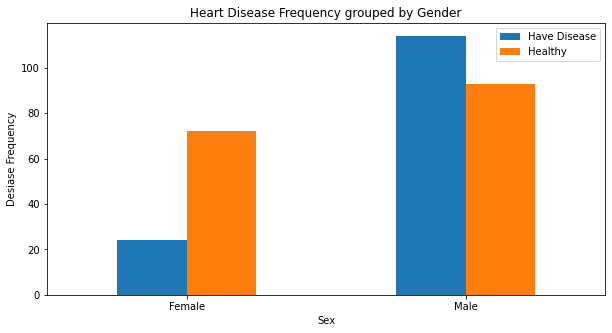

In [10]:
pd.crosstab(data.sex.replace([0, 1], ['Female', 'Male']),data.target).plot(kind="bar",figsize=(10, 5))
plt.xticks(rotation=0)
plt.title('Heart Disease Frequency grouped by Gender')
plt.xlabel('Sex')
plt.ylabel('Desiase Frequency')
plt.legend(["Have Disease", "Healthy"])

Finally, plot the distribution of the features using the sns pairplot function
- **Note** This code takes a couple of minutes to run

Using these plots note down some initial hypothesis on what maybe important features in our classifier? 

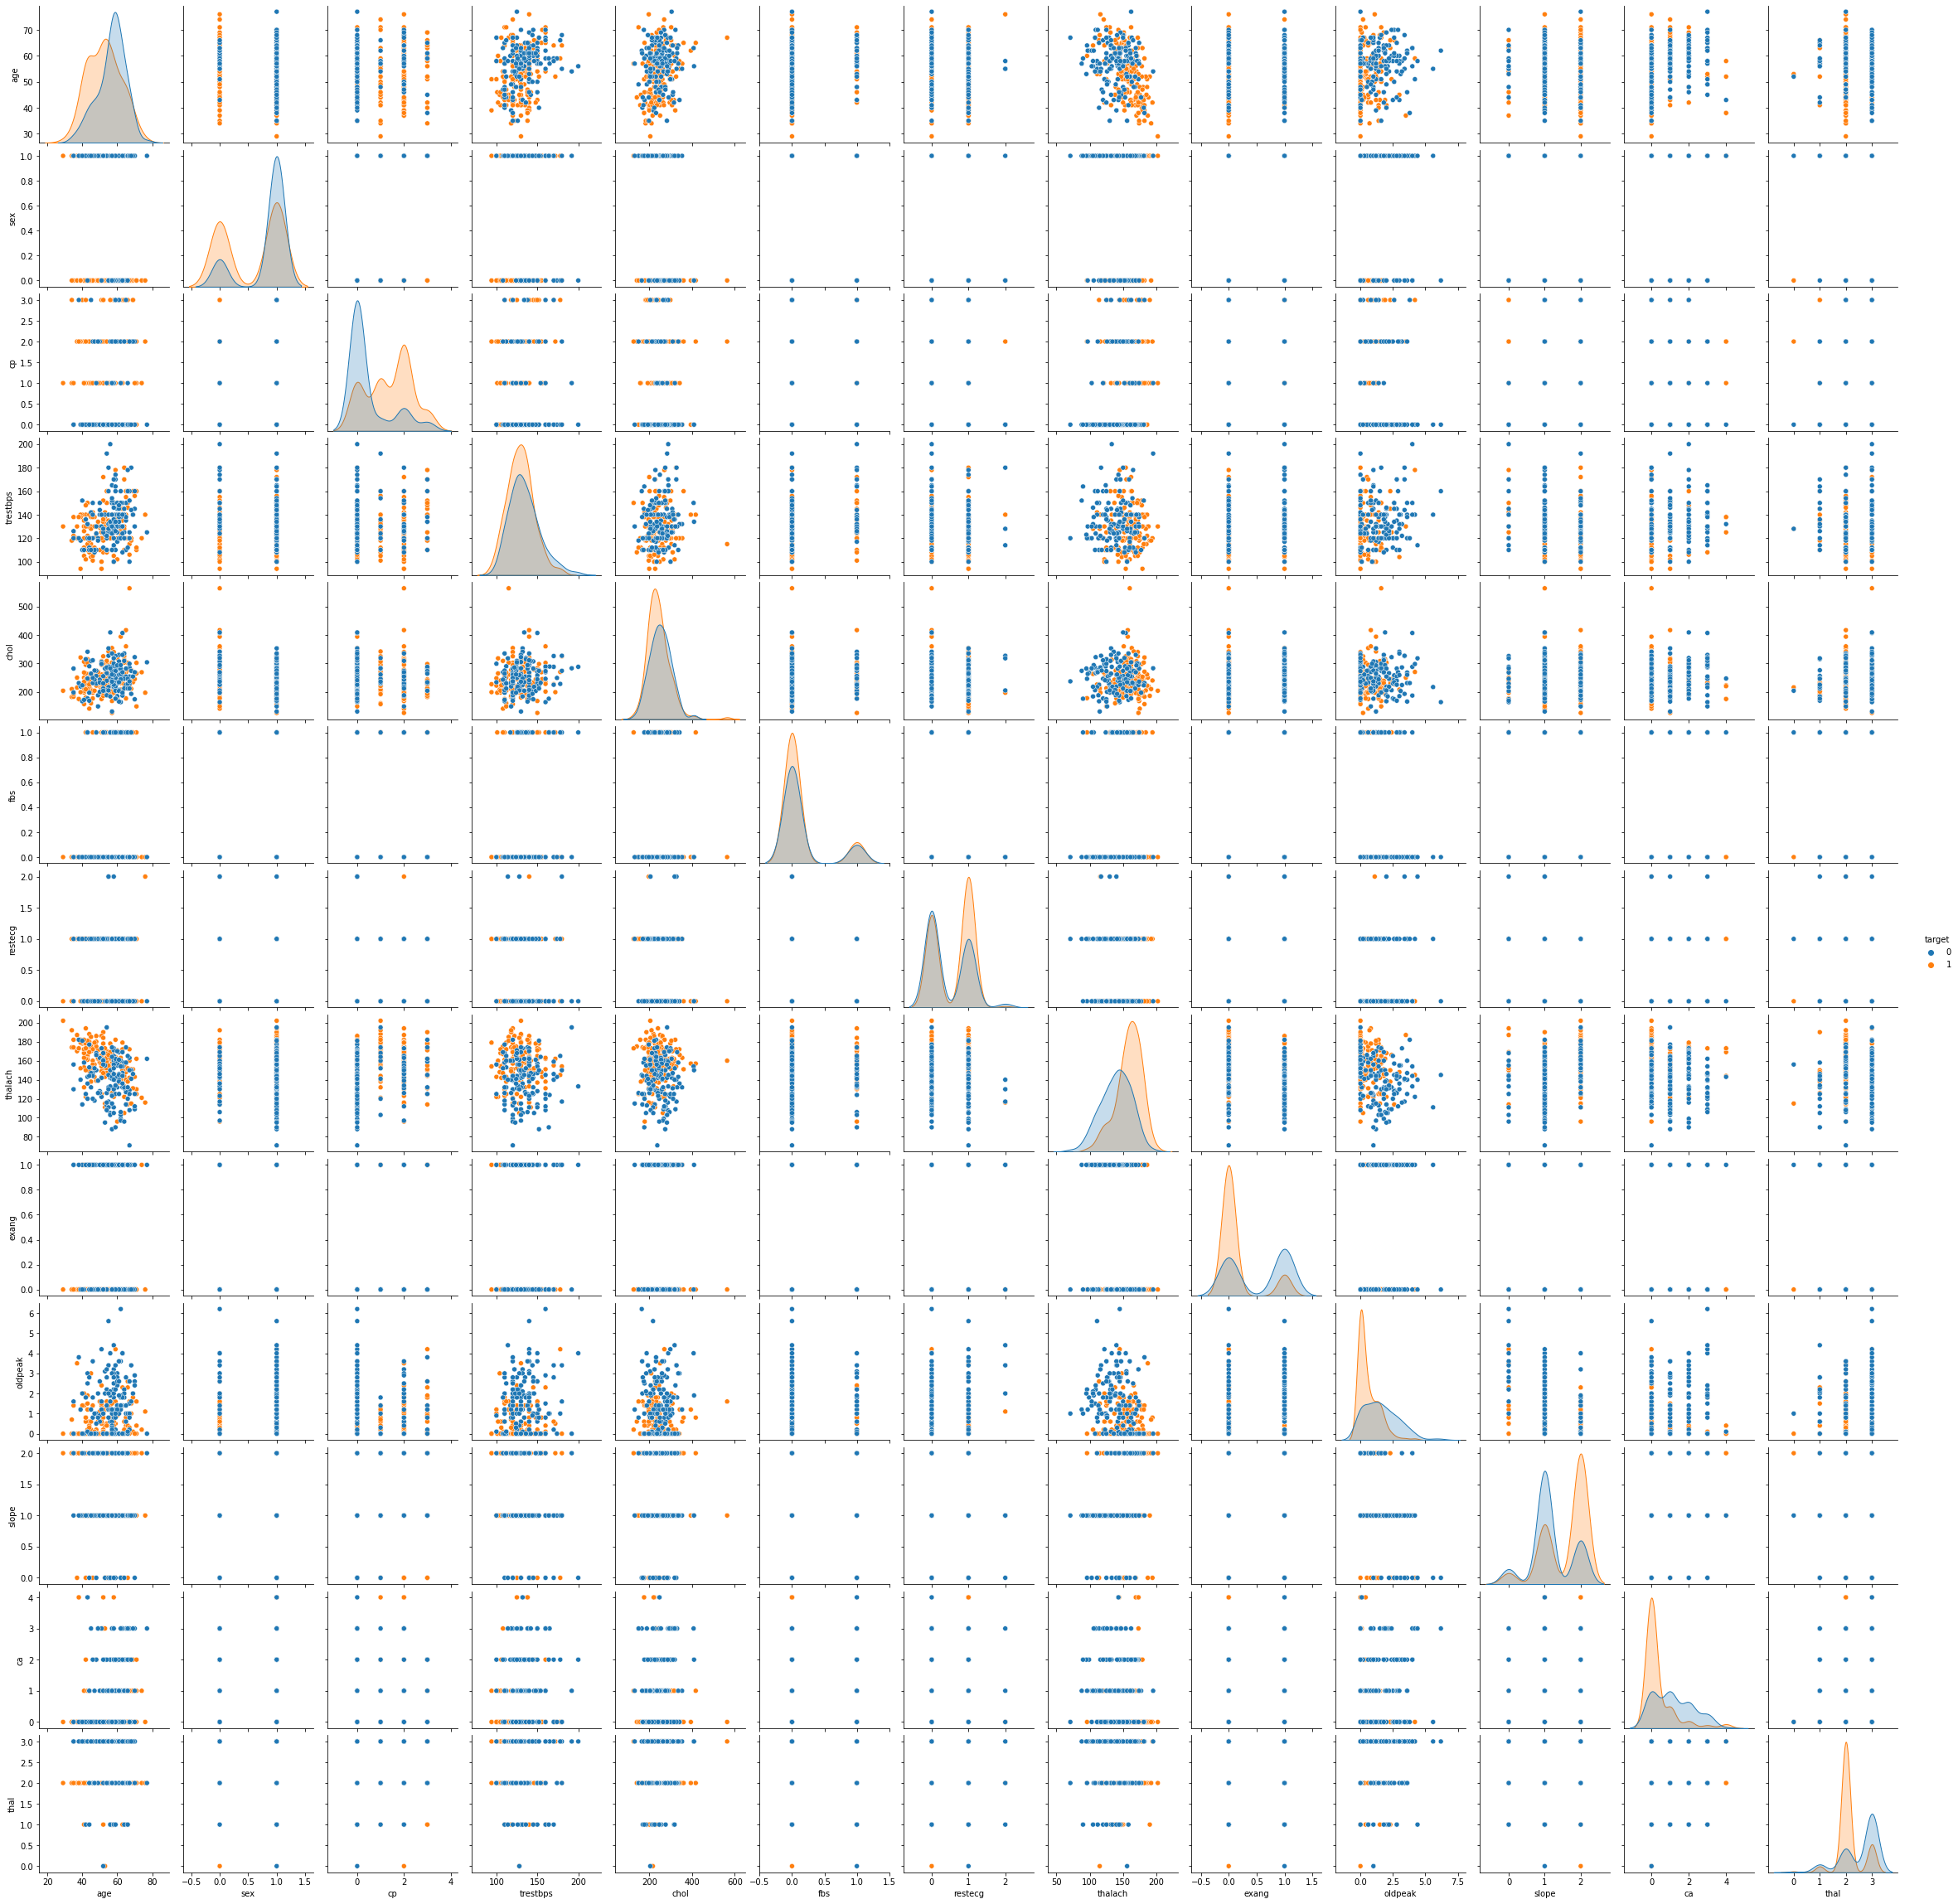

In [11]:
sns.pairplot(data, hue='target')

## Step 3 Perform the necessary preprocessing on data

Convert data from to required train and test arrays

In [12]:
# Seperate features from labes
X = data.drop(columns='target')
y = data['target']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

# Convert to numpy arrays
X_train = X_train.values 
X_test = X_test.values 

y_train = y_train.values 
y_test = y_test.values

# Parameters needed for setting the input shapes in our model
n_features =  X_train.shape[1]

# one hot encode labels for softmax
y_train_vec = to_categorical(y_train, 2)
y_test_vec = to_categorical(y_test, 2)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Step 4 Train Classifier

**Question** Descibe the model being built below

In [13]:
# define the keras model
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=n_features, activation='relu'))  
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    return model

**Question** What are the key characteristic of our model training set-up?

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________


2022-06-06 11:35:24.112901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-06 11:35:24.112928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-06 11:35:24.112946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (changhyun-MS-7B89): /proc/driver/nvidia/version does not exist
2022-06-06 11:35:24.113208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


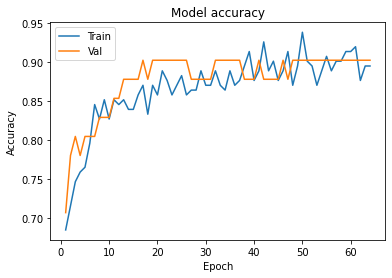

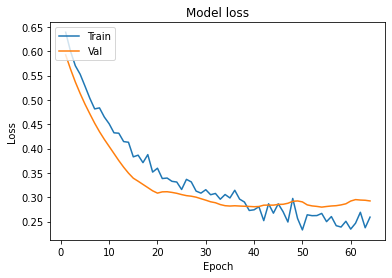

In [14]:
model = create_model()

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train_vec, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)

plot_learningCurve(history, EPOCHS)

**Question** We are using softmax and categorical_crossentropy in this task as LIME works with probabilistic outputs. If we did not need probabilistic outputs, what other final layer activation function and loss function combination could we use for this task?

Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.7800
test loss, test acc: [0.5823681354522705, 0.7799999713897705]
4/4 [==============================] - 0s 2ms/step


<AxesSubplot:>

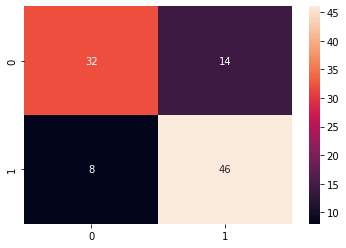

In [15]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test_vec)
print("test loss, test acc:", results)

y_pred_vec = model.predict(X_test)
y_pred = np.argmax(y_pred_vec, axis=1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

To help find interesting example to expalin, we need identify all correctly and incorrectly classified examples per class. The following function identifes all True Positive, False Negative, False Positive and True Negative samples in the test data

**Question** What do these terms (True Positive etc) mean?

In [16]:
def perf_measure(y_actual, y_pred):
    TP = []
    FP = []
    TN = []
    FN = []
    counter = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP.append(counter)
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP.append(counter)
        if y_actual[i]==y_pred[i]==0:
           TN.append(counter)
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN.append(counter)
        counter += 1

    return(TP, FP, TN, FN)

In [17]:
True_Positive, False_Negative, False_Positive, True_Negative = perf_measure(y_test, y_pred)

## Step 5 Create Explanations

To start explaining the model we need to create a tabular explainer `object`, which expects the following parameters:
- `training_data`: The data used to train the model. This must be in a Numpy array format.
- `feature_names`: The column names from the training set
- `class_names`: The distinct classes from the target variable
- `mode`: The type of problem being solved (classification in this case)

In [18]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns,
    class_names=['absence','presence'],
    mode='classification'
)

**We can now start explaining!** 

Call the explain_instance function to explain the prediction. 

The following parameters are required:
- `data_row`: a single observation from the dataset
- `predict_fn`: a function used to make predictions

Explaining a correctly classified heart disease instance. 

**Question** Do any of the features used in the explination match your inital hypothises on important features? 

In [19]:
exp = explainer.explain_instance(
    data_row=X_test[True_Positive[0]], 
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True)

157/157 [==============================] - 0s 1ms/step


Explaining a incorrectly classified heart disease instance

In [20]:
exp = explainer.explain_instance(
    data_row=X_test[False_Positive[0]], 
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True)

157/157 [==============================] - 0s 2ms/step


Explaining a correctly classified absence of heart disease instance

In [21]:
exp = explainer.explain_instance(
    data_row=X_test[True_Negative[0]], 
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True)

157/157 [==============================] - 0s 1ms/step


Explaining a incorrectly classified absence of heart disease instance

In [22]:
exp = explainer.explain_instance(
    data_row=X_test[False_Negative[0]], 
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True)

157/157 [==============================] - 0s 1ms/step


## Exercise 1

Create LIME explinations for a *different* classifier (prefereably not a slightly different feedforward neural network)

## Exercise 2

Implement LIME explinations for the *Breast Cancer Wisconsin Diagnostic Dataset* from Practical 4